In [67]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import seaborn as sns
from functions.adf_check import adf_check
from functions.best_model_arma import best_model_arma
from functions.acf_pacf import acf_pacf
from functions.kmeans import KMeans
from functions.isolation_forest import IsolationForest
from functions.one_class_svm import OneClassSVM

In [68]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()
df = df.set_index("dt")

c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [69]:
df

,Country,Country_ISO,AverageTemperature
dt,,,
1833-01-01,Afghanistan,AFG,1.145000
1833-02-01,Afghanistan,AFG,2.168400
1833-03-01,Afghanistan,AFG,6.516200
1833-04-01,Afghanistan,AFG,12.832200
1833-05-01,Afghanistan,AFG,18.544800
...,...,...,...
2013-04-01,Zimbabwe,ZWE,19.770143
2013-05-01,Zimbabwe,ZWE,17.851714
2013-06-01,Zimbabwe,ZWE,16.527143


In [70]:
# df_month = df.groupby(['Country', df.index])['AverageTemperature'].mean().reset_index()

# # Rename the columns for clarity
# df_month.columns = ['Country', 'dt', 'AverageTemperature']

# # Now, df_country_year contains the average temperature per year per country
# df_month = df_month.dropna()

# df_month = df_month.set_index("dt")

# df_month

In [71]:
# First, group by both 'Country' and year and calculate the mean temperature
df_country_year = df.groupby(['Country',"Country_ISO", df.index.year])['AverageTemperature'].mean().reset_index()

# Rename the columns for clarity
df_country_year.columns = ['Country',"Country_ISO", 'Year', 'AverageTemperature']

# Now, df_country_year contains the average temperature per year per country
df_country_year = df_country_year.dropna()

df_country_year = df_country_year.set_index("Year")

df_country_year

C:\Users\gaute\AppData\Local\Temp\ipykernel_2424\3696898959.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Country,Country_ISO,AverageTemperature
Year,,,
1833,Afghanistan,AFG,13.091150
1834,Afghanistan,AFG,13.093600
1835,Afghanistan,AFG,13.959233
1837,Afghanistan,AFG,14.537718
1838,Afghanistan,AFG,11.326802
...,...,...,...
2009,Zimbabwe,ZWE,20.106405
2010,Zimbabwe,ZWE,20.741714
2011,Zimbabwe,ZWE,20.366060


# Clustering

In [72]:
class KMeans2:
    def __init__(self, k=3, max_iter=100, n_init=10):
        self.k = k
        self.max_iter = max_iter
        # Number of times the KMeans algorithm will be run with different centroid seeds
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def __init_centroids(self, data):
        indices = np.random.choice(len(data), size=self.k, replace=False)
        return data[indices]

    ## New line to speed up the computation
    def __compute_inertia(self, data, centroids, labels):
        return np.sum(np.linalg.norm(data - centroids[labels], axis=1)**2)
        

    def __compute_distances(self, data, centroids):
        """Compute distances between each data point and the centroids."""
        return np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

    def fit(self, data):
        data = np.array(data, dtype=float)

        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for _ in range(self.n_init):
            centroids = self.__init_centroids(data)
            for _ in range(self.max_iter):
                distances = self.__compute_distances(data, centroids)
                labels = np.argmin(distances, axis=1)
                new_centroids = np.array(
                    [data[labels == i].mean(axis=0) for i in range(self.k)])
                if np.all(new_centroids == centroids):
                    break
                centroids = new_centroids
            inertia = self.__compute_inertia(data, centroids, labels)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels

        self.inertia_ = best_inertia
        self.centroids = best_centroids
        self.labels_ = best_labels

    def predict(self, data):
        data = np.array(data, dtype=float)
        distances = self.__compute_distances(data, self.centroids)
        return np.argmin(distances, axis=1)


In [73]:
# all_countries_data = df_country_year.drop(['Country',"Country_ISO"], axis=1)

# intertia_test1 = []
# for i in range(1, 11):
#     # Initialize and fit the KMeans model
#     kmeans = KMeans(k=i)
#     kmeans.fit(all_countries_data)
#     intertia_test1.append(kmeans.inertia_)

In [74]:
# all_countries_data = df_country_year.drop(['Country',"Country_ISO"], axis=1)

# intertia_test2 = []
# for i in range(1, 11):
#     # Initialize and fit the KMeans model
#     kmeans = KMeans2(k=i)
#     kmeans.fit(all_countries_data)
#     intertia_test2.append(kmeans.inertia_)

In [75]:
all_countries_data = df_country_year.drop(['Country',"Country_ISO"], axis=1)

inertia = []

for i in range(1, 11):
    # Initialize and fit the KMeans model
    kmeans = KMeans(k=i)
    kmeans.fit(all_countries_data)
    
    # Append inertia to the list
    inertia.append(kmeans.inertia_)
    

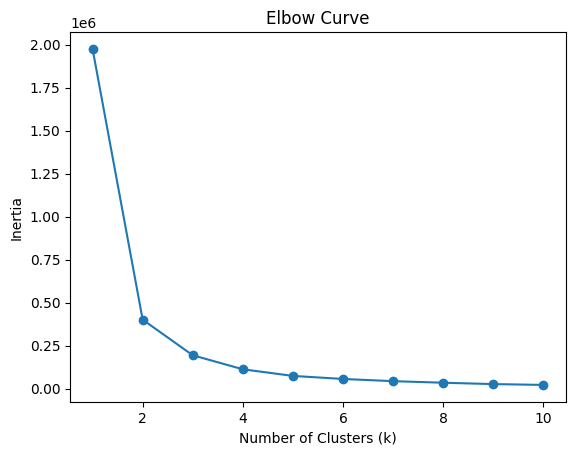

In [76]:
# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [77]:
model_kmeans = KMeans(k=4)
model_kmeans.fit(all_countries_data)


In [78]:
# Get cluster labels for each country
cluster_labels = model_kmeans.labels_

# # Append the cluster labels to the original DataFrame
df_country_with_clusters = df_country_year.copy()  # Make a copy to avoid modifying the original DataFrame
df_country_with_clusters['Cluster'] = cluster_labels


In [79]:
df_country_with_clusters

,Country,Country_ISO,AverageTemperature,Cluster
Year,,,,
1833,Afghanistan,AFG,13.091150,1
1834,Afghanistan,AFG,13.093600,1
1835,Afghanistan,AFG,13.959233,1
1837,Afghanistan,AFG,14.537718,1
1838,Afghanistan,AFG,11.326802,1
...,...,...,...,...
2009,Zimbabwe,ZWE,20.106405,2
2010,Zimbabwe,ZWE,20.741714,2
2011,Zimbabwe,ZWE,20.366060,2


C:\Users\gaute\AppData\Local\Temp\ipykernel_2424\1566151140.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




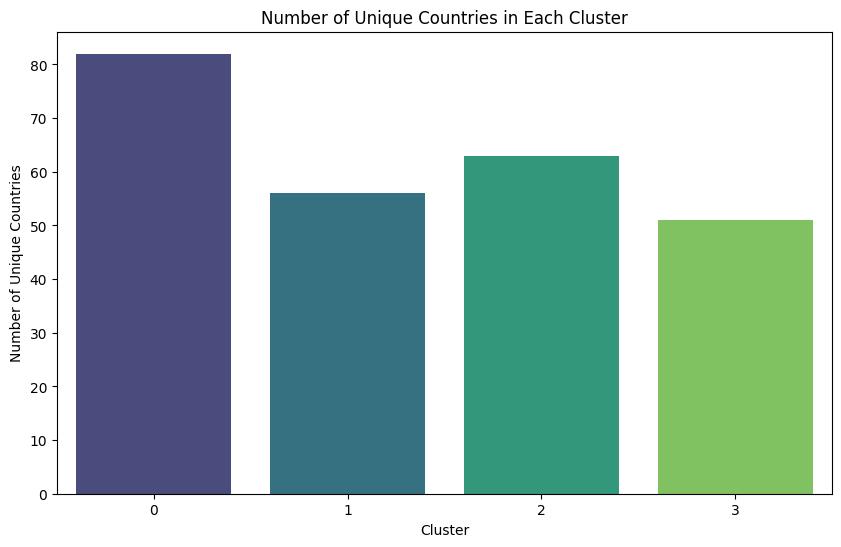

In [80]:
# Create a DataFrame to store unique countries in each cluster
unique_countries_df = df_country_with_clusters.groupby('Cluster')['Country'].unique().reset_index(name='UniqueCountries')
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y=unique_countries_df['UniqueCountries'].apply(len), data=unique_countries_df, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of Unique Countries')
plt.title('Number of Unique Countries in Each Cluster')
plt.show()


In [92]:


# Create a Choropleth map with clusters
fig = px.choropleth(
    df_country_with_clusters,
    locations='Country_ISO',
    color='Cluster',
    hover_name='Country',
    color_continuous_scale='Blues',
    title='Cluster Visualization on Choropleth Map'
)

fig.show()